In [1]:
# SGD（no）+ crossEntrpy + bs256 + tanh + lr0.005

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# 线性层
class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001):
        # 初始化模型参数
        self.W = np.random.normal(scale=0.01, size=(n_in, n_out))
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.batch_size = batch_size
    # 前向传播
    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output
    # 反向传播（SGD）
    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0) # relu的导数
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout # sigmoid的导数
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout # tanh的导数
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout
        # 更新参数
        self.W = self.W - self.dW * self.lr / self.batch_size
        self.b = self.b - self.db * self.lr / self.batch_size
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout


# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, 
                 lr=0.001, hidden_layer_sizes=(256,), 
                 activation='relu'):
        self.input_layer = LinearLayer(input_size, 
                                       hidden_layer_sizes[0], batch_size, 
                                       activation, lr=lr)
        self.classifier = LinearLayer(hidden_layer_sizes[-1], 
                                      num_classes, batch_size,
                                      None, lr=lr)
        self.softmax = SoftMax()

        self.layers = [self.input_layer]
        for i in range(len(hidden_layer_sizes) - 1):
            self.layers.append(LinearLayer(hidden_layer_sizes[i], 
                                           hidden_layer_sizes[i + 1],
                                           batch_size, activation, 
                                           lr=lr))
        self.layers.append(self.classifier)
        self.layers.append(self.softmax)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)

# 加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 150
batch_size = 256

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.005, hidden_layer_sizes=(256,), activation='tanh')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))  # 交叉熵损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            outputs = model.forward(data)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1 train: : 156batch [00:05, 30.88batch/s, train_acc=0.14]  
Epoch 1 valid: : 39batch [00:00, 82.20batch/s, valid_acc=0.14]  
Epoch 2 train: : 156batch [00:04, 33.67batch/s, train_acc=0.184]
Epoch 2 valid: : 39batch [00:00, 98.14batch/s, valid_acc=0.215]  
Epoch 3 train: : 156batch [00:04, 33.42batch/s, train_acc=0.242]
Epoch 3 valid: : 39batch [00:00, 96.09batch/s, valid_acc=0.258]
Epoch 4 train: : 156batch [00:04, 33.86batch/s, train_acc=0.266]
Epoch 4 valid: : 39batch [00:00, 101.88batch/s, valid_acc=0.269] 
Epoch 5 train: : 156batch [00:04, 34.40batch/s, train_acc=0.278]
Epoch 5 valid: : 39batch [00:00, 101.80batch/s, valid_acc=0.279] 
Epoch 6 train: : 156batch [00:04, 33.87batch/s, train_acc=0.288]
Epoch 6 valid: : 39batch [00:00, 102.54batch/s, valid_acc=0.291]
Epoch 7 train: : 156batch [00:04, 34.25batch/s, train_acc=0.293]
Epoch 7 valid: : 39batch [00:00, 88.30batch/s, valid_acc=0.3]   
Epoch 8 train: : 156batch [00:04, 33.01batch/s, train_acc=0.301]
Epoch 8 valid: : 39bat

KeyboardInterrupt: 

Epoch 1 train: : 156batch [00:02, 64.67batch/s, train_acc=0.245]
Epoch 1 valid: : 39batch [00:00, 194.81batch/s, valid_acc=0.303]
Epoch 2 train: : 156batch [00:02, 58.68batch/s, train_acc=0.315]
Epoch 2 valid: : 39batch [00:00, 163.76batch/s, valid_acc=0.331]
Epoch 3 train: : 156batch [00:03, 48.76batch/s, train_acc=0.339]
Epoch 3 valid: : 39batch [00:00, 171.66batch/s, valid_acc=0.337]
Epoch 4 train: : 156batch [00:02, 59.13batch/s, train_acc=0.351]
Epoch 4 valid: : 39batch [00:00, 173.07batch/s, valid_acc=0.361]
Epoch 5 train: : 156batch [00:02, 62.17batch/s, train_acc=0.362]
Epoch 5 valid: : 39batch [00:00, 165.66batch/s, valid_acc=0.379]
Epoch 6 train: : 156batch [00:02, 58.97batch/s, train_acc=0.371]
Epoch 6 valid: : 39batch [00:00, 165.70batch/s, valid_acc=0.383]
Epoch 7 train: : 156batch [00:02, 60.15batch/s, train_acc=0.377]
Epoch 7 valid: : 39batch [00:00, 207.99batch/s, valid_acc=0.347]
Epoch 8 train: : 156batch [00:02, 64.04batch/s, train_acc=0.385]
Epoch 8 valid: : 39batch 

测试精度: 48.75%


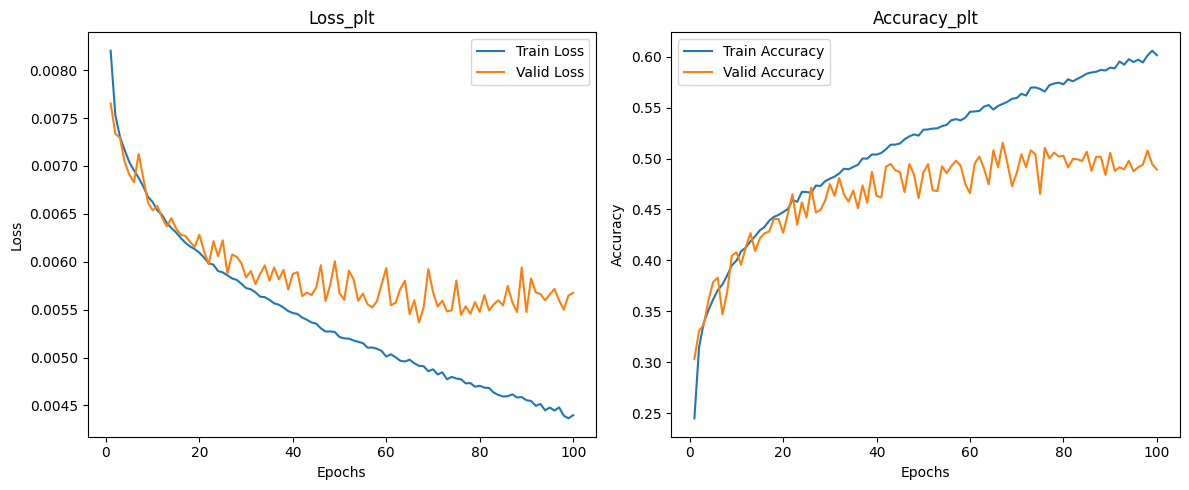

In [1]:
# SGD（no）+ crossEntrpy + bs256 + tanh + lr0.05 + epoch100

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# 线性层
class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001):
        self.W = np.random.normal(scale=0.01, size=(n_in, n_out))
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.batch_size = batch_size

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output

    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0)
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout
        self.W = self.W - self.dW * self.lr / self.batch_size
        self.b = self.b - self.db * self.lr / self.batch_size
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout


# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, hidden_layer_sizes=(256,), activation='relu'):
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, None, lr=lr)
        self.softmax = SoftMax()

        self.layers = [self.input_layer]
        for i in range(len(hidden_layer_sizes) - 1):
            self.layers.append(LinearLayer(hidden_layer_sizes[i], hidden_layer_sizes[i + 1], batch_size, activation, lr=lr))
        self.layers.append(self.classifier)
        self.layers.append(self.softmax)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)

# 下载并加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 100
batch_size = 256

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.05, hidden_layer_sizes=(256,), activation='tanh')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))  # 交叉熵损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            outputs = model.forward(data)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1 train: : 156batch [00:02, 65.21batch/s, train_acc=0.122] 
Epoch 1 valid: : 39batch [00:00, 210.75batch/s, valid_acc=0.141] 
Epoch 2 train: : 156batch [00:02, 66.20batch/s, train_acc=0.151] 
Epoch 2 valid: : 39batch [00:00, 211.53batch/s, valid_acc=0.166] 
Epoch 3 train: : 156batch [00:02, 65.45batch/s, train_acc=0.189]
Epoch 3 valid: : 39batch [00:00, 204.15batch/s, valid_acc=0.203]
Epoch 4 train: : 156batch [00:02, 62.96batch/s, train_acc=0.201]
Epoch 4 valid: : 39batch [00:00, 179.48batch/s, valid_acc=0.24] 
Epoch 5 train: : 156batch [00:02, 66.00batch/s, train_acc=0.218]
Epoch 5 valid: : 39batch [00:00, 184.83batch/s, valid_acc=0.217]
Epoch 6 train: : 156batch [00:02, 66.24batch/s, train_acc=0.223]
Epoch 6 valid: : 39batch [00:00, 210.48batch/s, valid_acc=0.22] 
Epoch 7 train: : 156batch [00:02, 66.63batch/s, train_acc=0.235]
Epoch 7 valid: : 39batch [00:00, 217.34batch/s, valid_acc=0.237]
Epoch 8 train: : 156batch [00:02, 66.73batch/s, train_acc=0.246]
Epoch 8 valid: : 39ba

测试精度: 41.04%


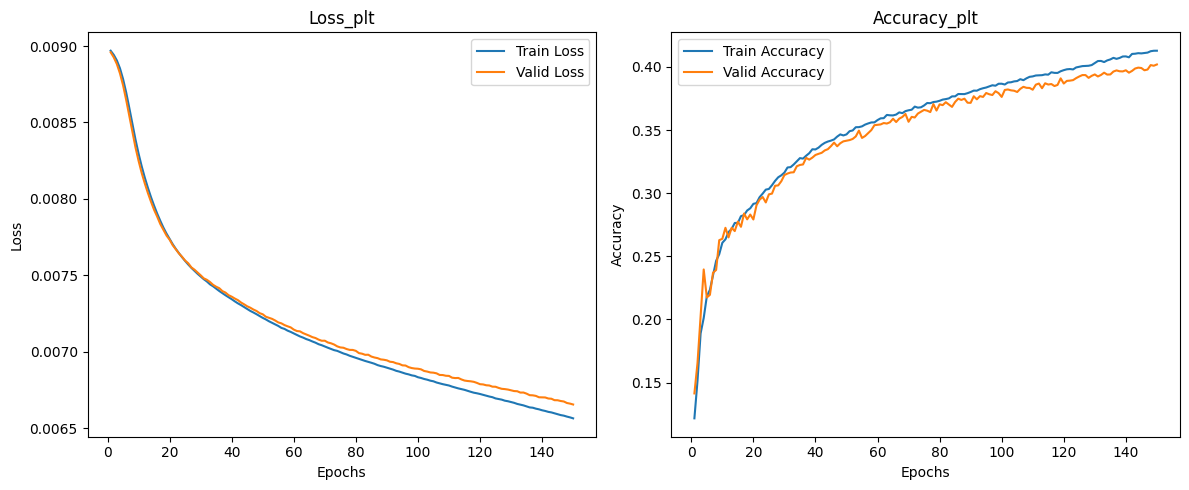

In [3]:
# SGD（no）+ crossEntrpy + bs256 + sigmoid + lr0.01

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# 线性层
class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001):
        self.W = np.random.normal(scale=0.01, size=(n_in, n_out))
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.batch_size = batch_size

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output

    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0)
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout
        self.W = self.W - self.dW * self.lr / self.batch_size
        self.b = self.b - self.db * self.lr / self.batch_size
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout


# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, hidden_layer_sizes=(256,), activation='relu'):
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, None, lr=lr)
        self.softmax = SoftMax()

        self.layers = [self.input_layer]
        for i in range(len(hidden_layer_sizes) - 1):
            self.layers.append(LinearLayer(hidden_layer_sizes[i], hidden_layer_sizes[i + 1], batch_size, activation, lr=lr))
        self.layers.append(self.classifier)
        self.layers.append(self.softmax)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)

# 下载并加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 150
batch_size = 256

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.01, hidden_layer_sizes=(256,), activation='sigmoid')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))  # 交叉熵损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            outputs = model.forward(data)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1 train: : 156batch [00:02, 66.09batch/s, train_acc=0.172]
Epoch 1 valid: : 39batch [00:00, 220.26batch/s, valid_acc=0.213]
Epoch 2 train: : 156batch [00:02, 65.61batch/s, train_acc=0.245]
Epoch 2 valid: : 39batch [00:00, 217.69batch/s, valid_acc=0.269]
Epoch 3 train: : 156batch [00:02, 65.87batch/s, train_acc=0.273]
Epoch 3 valid: : 39batch [00:00, 214.82batch/s, valid_acc=0.282]
Epoch 4 train: : 156batch [00:02, 65.52batch/s, train_acc=0.289]
Epoch 4 valid: : 39batch [00:00, 216.25batch/s, valid_acc=0.292]
Epoch 5 train: : 156batch [00:02, 65.33batch/s, train_acc=0.304]
Epoch 5 valid: : 39batch [00:00, 218.10batch/s, valid_acc=0.307]
Epoch 6 train: : 156batch [00:02, 59.29batch/s, train_acc=0.316]
Epoch 6 valid: : 39batch [00:00, 209.11batch/s, valid_acc=0.32] 
Epoch 7 train: : 156batch [00:02, 59.63batch/s, train_acc=0.327]
Epoch 7 valid: : 39batch [00:00, 186.40batch/s, valid_acc=0.325]
Epoch 8 train: : 156batch [00:02, 65.79batch/s, train_acc=0.335]
Epoch 8 valid: : 39batch 

测试精度: 49.33%


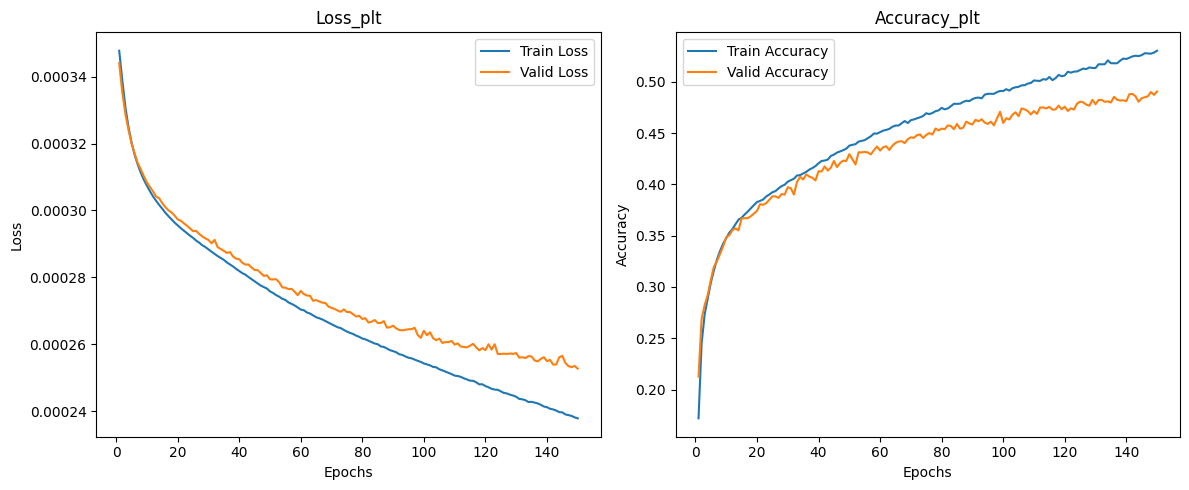

In [5]:
# SGD（no）+ MSE + bs256 + tanh + lr0.01

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# 线性层
class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001):
        self.W = np.random.normal(scale=0.01, size=(n_in, n_out))
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.batch_size = batch_size

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output

    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0)
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout
        self.W = self.W - self.dW * self.lr / self.batch_size
        self.b = self.b - self.db * self.lr / self.batch_size
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout


# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, hidden_layer_sizes=(256,), activation='relu'):
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, None, lr=lr)
        self.softmax = SoftMax()

        self.layers = [self.input_layer]
        for i in range(len(hidden_layer_sizes) - 1):
            self.layers.append(LinearLayer(hidden_layer_sizes[i], hidden_layer_sizes[i + 1], batch_size, activation, lr=lr))
        self.layers.append(self.classifier)
        self.layers.append(self.softmax)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)

# 下载并加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 150
batch_size = 256

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.01, hidden_layer_sizes=(256,), activation='tanh')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(np.square(outputs - label))  # MSE 损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(np.square(outputs - label))  # MSE 损失
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            outputs = model.forward(data)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1 train: : 156batch [00:02, 64.65batch/s, train_acc=0.157] 
Epoch 1 valid: : 39batch [00:00, 212.85batch/s, valid_acc=0.239]
Epoch 2 train: : 156batch [00:02, 66.23batch/s, train_acc=0.25] 
Epoch 2 valid: : 39batch [00:00, 217.29batch/s, valid_acc=0.274]
Epoch 3 train: : 156batch [00:02, 66.08batch/s, train_acc=0.273]
Epoch 3 valid: : 39batch [00:00, 214.59batch/s, valid_acc=0.287]
Epoch 4 train: : 156batch [00:02, 67.17batch/s, train_acc=0.29] 
Epoch 4 valid: : 39batch [00:00, 216.75batch/s, valid_acc=0.298]
Epoch 5 train: : 156batch [00:02, 65.76batch/s, train_acc=0.302]
Epoch 5 valid: : 39batch [00:00, 215.40batch/s, valid_acc=0.313]
Epoch 6 train: : 156batch [00:02, 64.54batch/s, train_acc=0.314]
Epoch 6 valid: : 39batch [00:00, 165.95batch/s, valid_acc=0.326]
Epoch 7 train: : 156batch [00:02, 62.73batch/s, train_acc=0.325]
Epoch 7 valid: : 39batch [00:00, 193.08batch/s, valid_acc=0.334]
Epoch 8 train: : 156batch [00:02, 63.76batch/s, train_acc=0.334]
Epoch 8 valid: : 39batch

测试精度: 49.26%


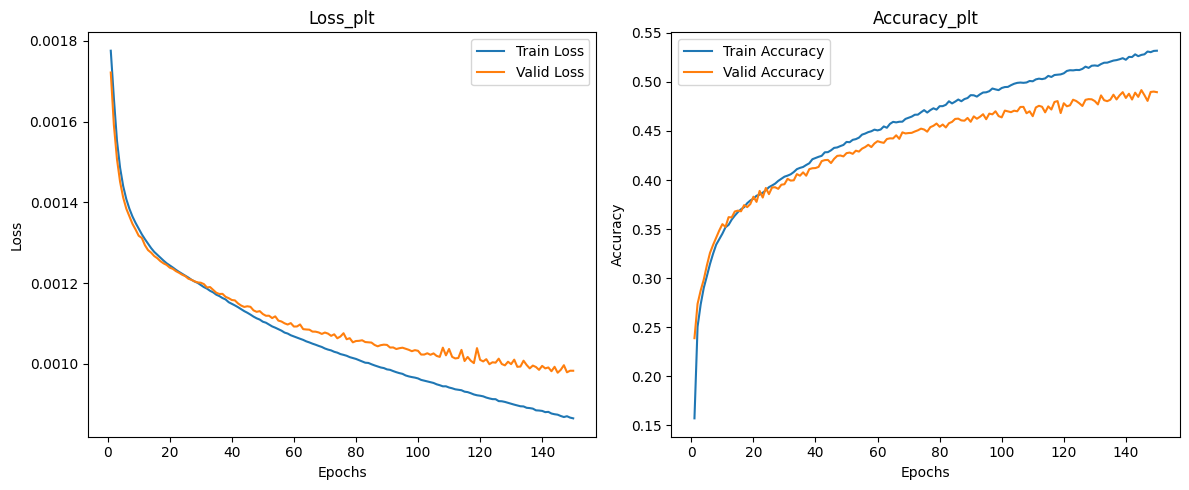

In [6]:
# focal+ MSE + bs256 + tanh + lr0.01

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# 线性层
class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001):
        self.W = np.random.normal(scale=0.01, size=(n_in, n_out))
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.batch_size = batch_size

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output

    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0)
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout
        self.W = self.W - self.dW * self.lr / self.batch_size
        self.b = self.b - self.db * self.lr / self.batch_size
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout


# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, hidden_layer_sizes=(256,), activation='relu'):
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, None, lr=lr)
        self.softmax = SoftMax()

        self.layers = [self.input_layer]
        for i in range(len(hidden_layer_sizes) - 1):
            self.layers.append(LinearLayer(hidden_layer_sizes[i], hidden_layer_sizes[i + 1], batch_size, activation, lr=lr))
        self.layers.append(self.classifier)
        self.layers.append(self.softmax)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)
            
# Focal Loss实现
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    # 加1e-8防止log(0)
    epsilon = 1e-8
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)  
    
    # 计算交叉熵损失
    cross_entropy = -y_true * np.log(y_pred)
    
    # 计算 Focal Loss 的权重
    weight = alpha * np.power(1 - y_pred, gamma)
    
    # 计算最终的 Focal Loss
    focal_loss = weight * cross_entropy
    return np.mean(np.sum(focal_loss, axis=1))

# 下载并加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 150
batch_size = 256

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.01, hidden_layer_sizes=(256,), activation='tanh')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播
            outputs = model.forward(data)
            loss = focal_loss(label, outputs, gamma=2.0, alpha=0.25)  # Focal 损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播
            outputs = model.forward(data)
            loss = focal_loss(label, outputs, gamma=2.0, alpha=0.25)  # Focal 损失
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            outputs = model.forward(data)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1 train: : 156batch [00:02, 53.22batch/s, train_acc=0.151] 
Epoch 1 valid: : 39batch [00:00, 139.35batch/s, valid_acc=0.24]  
Epoch 2 train: : 156batch [00:02, 57.70batch/s, train_acc=0.195]
Epoch 2 valid: : 39batch [00:00, 203.61batch/s, valid_acc=0.259]
Epoch 3 train: : 156batch [00:02, 56.70batch/s, train_acc=0.216]
Epoch 3 valid: : 39batch [00:00, 208.58batch/s, valid_acc=0.298]
Epoch 4 train: : 156batch [00:02, 56.95batch/s, train_acc=0.229]
Epoch 4 valid: : 39batch [00:00, 212.26batch/s, valid_acc=0.312]
Epoch 5 train: : 156batch [00:02, 57.73batch/s, train_acc=0.238]
Epoch 5 valid: : 39batch [00:00, 214.54batch/s, valid_acc=0.325]
Epoch 6 train: : 156batch [00:02, 57.60batch/s, train_acc=0.245]
Epoch 6 valid: : 39batch [00:00, 206.81batch/s, valid_acc=0.332]
Epoch 7 train: : 156batch [00:02, 56.32batch/s, train_acc=0.247]
Epoch 7 valid: : 39batch [00:00, 218.40batch/s, valid_acc=0.337]
Epoch 8 train: : 156batch [00:02, 56.51batch/s, train_acc=0.246]
Epoch 8 valid: : 39batc

测试精度: 41.72%


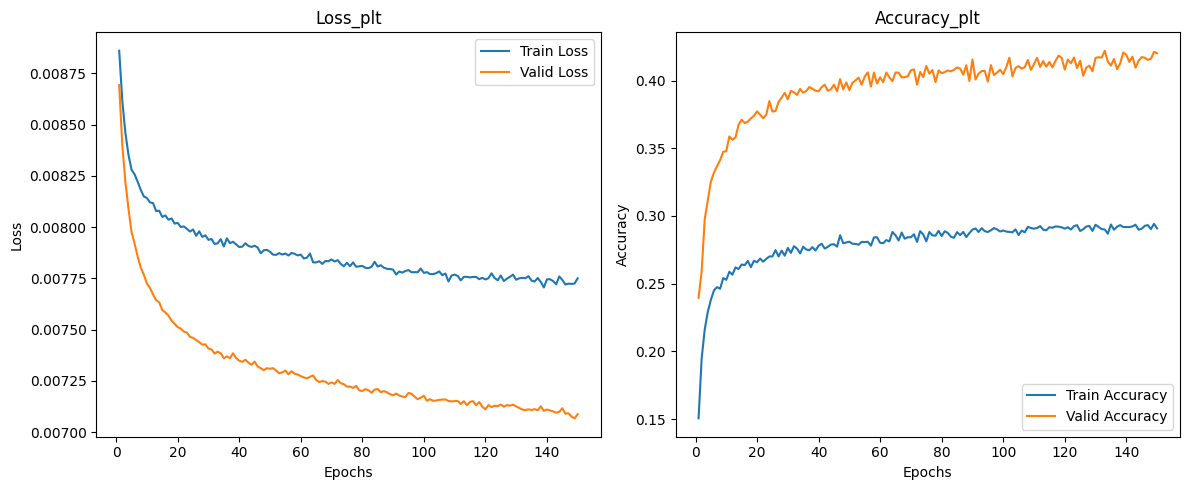

In [7]:
# SGD（no）+ crossEntrpy + bs256 + tanh + lr0.01 + dropout

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# 线性层
class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001):
        self.W = np.random.normal(scale=0.01, size=(n_in, n_out))
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.batch_size = batch_size

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output

    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0)
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout
        self.W = self.W - self.dW * self.lr / self.batch_size
        self.b = self.b - self.db * self.lr / self.batch_size
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout

class Dropout:
    def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate
        self.mask = None

    def forward(self, x, training=True):
        if training:
            # 在训练时生成一个mask，用于随机关闭神经元
            self.mask = np.random.binomial(1, 1 - self.dropout_rate, size=x.shape) / (1 - self.dropout_rate)
            return x * self.mask
        else:
            # 在测试时，直接返回输入数据
            return x

    def backward(self, dout):
        # 反向传播时只传播未关闭神经元的梯度
        return dout * self.mask

# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, hidden_layer_sizes=(256,), activation='relu', dropout_rate=0.5):
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        self.dropout1 = Dropout(dropout_rate)  # 第一个 Dropout
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, None, lr=lr)
        self.dropout2 = Dropout(dropout_rate)  # 第二个 Dropout
        self.softmax = SoftMax()

        self.layers = [self.input_layer, self.dropout1]  # 加入 Dropout1
        for i in range(len(hidden_layer_sizes) - 1):
            self.layers.append(LinearLayer(hidden_layer_sizes[i], hidden_layer_sizes[i + 1], batch_size, activation, lr=lr))
        self.layers.append(self.classifier)
        self.layers.append(self.dropout2)  # 加入 Dropout2
        self.layers.append(self.softmax)

    def forward(self, x, training=True):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, training)  # 在训练时使用 Dropout
            else:
                x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)

# 下载并加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 150
batch_size = 256

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.01, hidden_layer_sizes=(256,), activation='tanh')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播（训练时启用 Dropout）
            outputs = model.forward(data, training=True)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))  # 交叉熵损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段（禁用 Dropout）
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播（验证时禁用 Dropout）
            outputs = model.forward(data, training=False)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)
    

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            # 测试时禁用 Dropout
            outputs = model.forward(data, training=False)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1 train: : 156batch [00:02, 54.47batch/s, train_acc=0.158] 
Epoch 1 valid: : 39batch [00:00, 183.02batch/s, valid_acc=0.235]
Epoch 2 train: : 156batch [00:02, 56.42batch/s, train_acc=0.23] 
Epoch 2 valid: : 39batch [00:00, 181.29batch/s, valid_acc=0.262]
Epoch 3 train: : 156batch [00:02, 53.98batch/s, train_acc=0.254]
Epoch 3 valid: : 39batch [00:00, 177.79batch/s, valid_acc=0.278]
Epoch 4 train: : 156batch [00:02, 56.42batch/s, train_acc=0.269]
Epoch 4 valid: : 39batch [00:00, 208.80batch/s, valid_acc=0.289]
Epoch 5 train: : 156batch [00:02, 58.28batch/s, train_acc=0.288]
Epoch 5 valid: : 39batch [00:00, 211.92batch/s, valid_acc=0.306]
Epoch 6 train: : 156batch [00:02, 58.08batch/s, train_acc=0.295]
Epoch 6 valid: : 39batch [00:00, 211.37batch/s, valid_acc=0.315]
Epoch 7 train: : 156batch [00:02, 58.31batch/s, train_acc=0.301]
Epoch 7 valid: : 39batch [00:00, 217.19batch/s, valid_acc=0.326]
Epoch 8 train: : 156batch [00:02, 58.16batch/s, train_acc=0.308]
Epoch 8 valid: : 39batch

测试精度: 46.60%


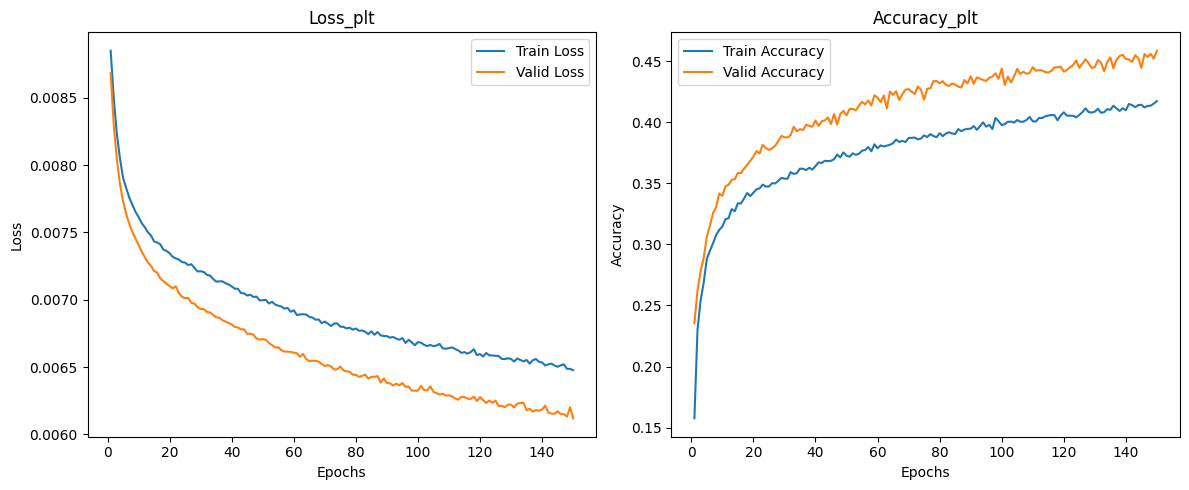

In [10]:
# SGD（no）+ crossEntrpy + bs256 + tanh + lr0.01 + dropout0.2

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# 线性层
class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001):
        self.W = np.random.normal(scale=0.01, size=(n_in, n_out))
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.batch_size = batch_size

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output

    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0)
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout
        self.W = self.W - self.dW * self.lr / self.batch_size
        self.b = self.b - self.db * self.lr / self.batch_size
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout

class Dropout:
    def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate
        self.mask = None

    def forward(self, x, training=True):
        if training:
            # 在训练时生成一个mask，用于随机关闭神经元
            self.mask = np.random.binomial(1, 1 - self.dropout_rate, size=x.shape) / (1 - self.dropout_rate)
            return x * self.mask
        else:
            # 在测试时，直接返回输入数据
            return x

    def backward(self, dout):
        # 反向传播时只传播未关闭神经元的梯度
        return dout * self.mask

# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, 
                 hidden_layer_sizes=(256,), activation='relu', dropout_rate=0.2):
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        self.dropout1 = Dropout(dropout_rate)  # 第一个 Dropout
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, None, lr=lr)
        self.dropout2 = Dropout(dropout_rate)  # 第二个 Dropout
        self.softmax = SoftMax()

        self.layers = [self.input_layer, self.dropout1]  # 加入 Dropout1
        for i in range(len(hidden_layer_sizes) - 1):
            self.layers.append(LinearLayer(hidden_layer_sizes[i], hidden_layer_sizes[i + 1], 
                                           batch_size, activation, lr=lr))
        self.layers.append(self.classifier)
        self.layers.append(self.dropout2)  # 加入 Dropout2
        self.layers.append(self.softmax)

    def forward(self, x, training=True):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, training)  # 在训练时使用 Dropout
            else:
                x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)

# 下载并加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 150
batch_size = 256

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.01, hidden_layer_sizes=(256,), activation='tanh')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播（训练时启用 Dropout）
            outputs = model.forward(data, training=True)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))  # 交叉熵损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段（禁用 Dropout）
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播（验证时禁用 Dropout）
            outputs = model.forward(data, training=False)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)
    

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            # 测试时禁用 Dropout
            outputs = model.forward(data, training=False)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1 train: : 156batch [00:03, 49.11batch/s, train_acc=0.194] 
Epoch 1 valid: : 39batch [00:00, 221.24batch/s, valid_acc=0.231]
Epoch 2 train: : 156batch [00:03, 49.66batch/s, train_acc=0.247]
Epoch 2 valid: : 39batch [00:00, 215.98batch/s, valid_acc=0.257]
Epoch 3 train: : 156batch [00:03, 46.96batch/s, train_acc=0.274]
Epoch 3 valid: : 39batch [00:00, 182.82batch/s, valid_acc=0.278]
Epoch 4 train: : 156batch [00:03, 44.04batch/s, train_acc=0.293]
Epoch 4 valid: : 39batch [00:00, 95.61batch/s, valid_acc=0.291]
Epoch 5 train: : 156batch [00:03, 42.78batch/s, train_acc=0.311]
Epoch 5 valid: : 39batch [00:00, 218.16batch/s, valid_acc=0.302]
Epoch 6 train: : 156batch [00:02, 52.76batch/s, train_acc=0.319]
Epoch 6 valid: : 39batch [00:00, 243.98batch/s, valid_acc=0.306]
Epoch 7 train: : 156batch [00:02, 52.36batch/s, train_acc=0.328]
Epoch 7 valid: : 39batch [00:00, 219.91batch/s, valid_acc=0.316]
Epoch 8 train: : 156batch [00:03, 49.00batch/s, train_acc=0.335]
Epoch 8 valid: : 39batch 

测试精度: 44.83%


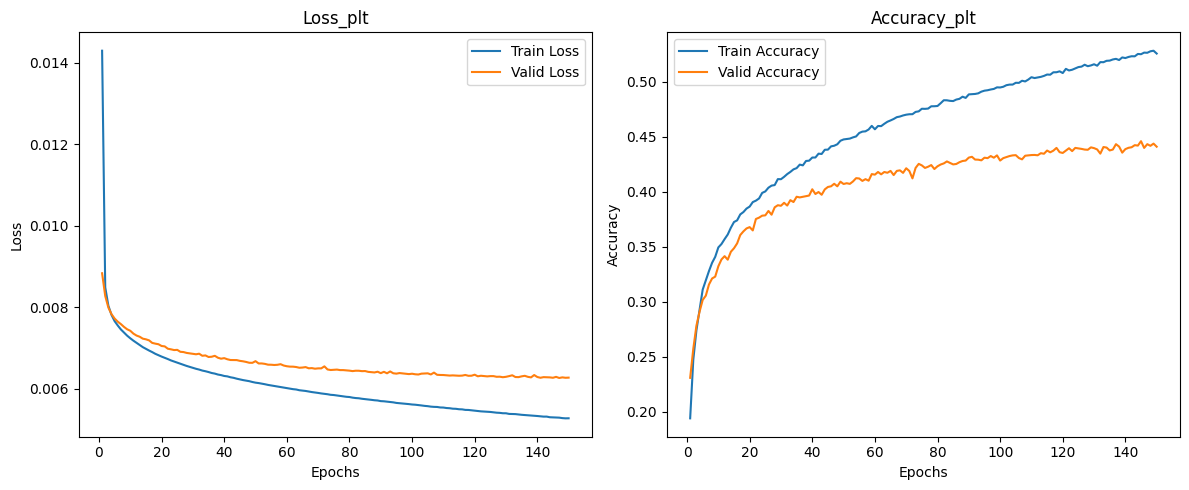

In [8]:
# SGD（no）+ crossEntrpy + bs256 + tanh + lr0.01 + kaiming
import torch
import torch.nn.init as init
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001):
        # 使用 PyTorch 的 Kaiming 初始化
        self.W = torch.empty((n_in, n_out), dtype=torch.float32)
        init.kaiming_normal_(self.W, nonlinearity='tanh')  # 适合 tanh 激活函数的初始化方式
        
        self.b = np.zeros((batch_size, n_out), dtype=np.float32)  # 置零初始化偏置
        self.activation = activation
        self.lr = lr
        self.batch_size = batch_size

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W.numpy()) + self.b  # 将权重从 torch.Tensor 转为 numpy
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output

    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0)
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        
        dx = np.dot(dout, self.W.numpy().T)  # 继续使用 numpy 进行梯度计算
        self.dW = np.dot(self.x.T, dout)
        self.db = dout
        
        # 更新权重和偏置
        self.W -= torch.from_numpy(self.dW * self.lr / self.batch_size).float()  # 使用 torch 更新
        self.b -= self.db * self.lr / self.batch_size
        
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout


# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, hidden_layer_sizes=(256,), activation='relu'):
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, None, lr=lr)
        self.softmax = SoftMax()

        self.layers = [self.input_layer]
        for i in range(len(hidden_layer_sizes) - 1):
            self.layers.append(LinearLayer(hidden_layer_sizes[i], hidden_layer_sizes[i + 1], batch_size, activation, lr=lr))
        self.layers.append(self.classifier)
        self.layers.append(self.softmax)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)

# 下载并加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 150
batch_size = 256

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.01, hidden_layer_sizes=(256,), activation='relu')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))  # 交叉熵损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            outputs = model.forward(data)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1 train: : 156batch [00:03, 47.12batch/s, train_acc=0.12]  
Epoch 1 valid: : 39batch [00:00, 211.30batch/s, valid_acc=0.188]
Epoch 2 train: : 156batch [00:03, 48.13batch/s, train_acc=0.209]
Epoch 2 valid: : 39batch [00:00, 212.83batch/s, valid_acc=0.245]
Epoch 3 train: : 156batch [00:03, 48.45batch/s, train_acc=0.241]
Epoch 3 valid: : 39batch [00:00, 211.24batch/s, valid_acc=0.264]
Epoch 4 train: : 156batch [00:03, 47.42batch/s, train_acc=0.266]
Epoch 4 valid: : 39batch [00:00, 205.68batch/s, valid_acc=0.295]
Epoch 5 train: : 156batch [00:03, 42.29batch/s, train_acc=0.282]
Epoch 5 valid: : 39batch [00:00, 170.83batch/s, valid_acc=0.3]  
Epoch 6 train: : 156batch [00:03, 42.59batch/s, train_acc=0.292]
Epoch 6 valid: : 39batch [00:00, 186.47batch/s, valid_acc=0.317]
Epoch 7 train: : 156batch [00:03, 46.60batch/s, train_acc=0.304]
Epoch 7 valid: : 39batch [00:00, 219.10batch/s, valid_acc=0.323]
Epoch 8 train: : 156batch [00:03, 49.89batch/s, train_acc=0.313]
Epoch 8 valid: : 39batch

测试精度: 51.30%


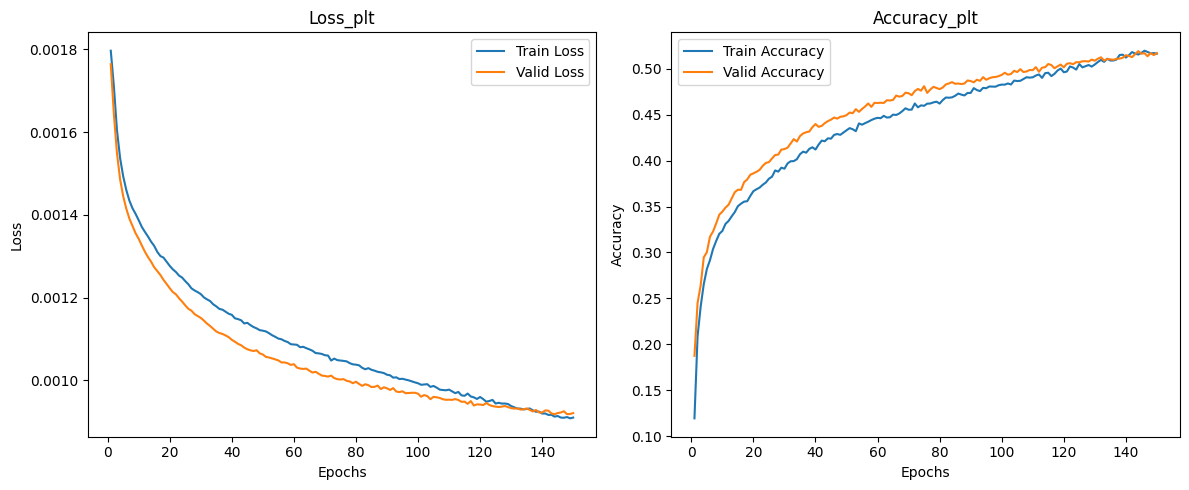

In [11]:
# SGD（0.9）+ fucal + bs256 + relu + lr0.01 + dropout0.1  用下面的

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# 线性层
class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001, momentum=0.9):
        self.W = np.random.normal(scale=0.01, size=(n_in, n_out))
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.momentum = momentum
        self.batch_size = batch_size
        
        # 初始化动量项为 0
        self.vW = np.zeros_like(self.W)
        self.vb = np.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output

    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0)
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout

        # 更新动量项
        self.vW = self.momentum * self.vW + (1 - self.momentum) * self.dW
        self.vb = self.momentum * self.vb + (1 - self.momentum) * self.db

        # 更新权重和偏置
        self.W = self.W - self.lr * self.vW / self.batch_size
        self.b = self.b - self.lr * self.vb / self.batch_size
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout

class Dropout:
    def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate
        self.mask = None

    def forward(self, x, training=True):
        if training:
            # 在训练时生成一个mask，用于随机关闭神经元
            self.mask = np.random.binomial(1, 1 - self.dropout_rate, size=x.shape) / (1 - self.dropout_rate)
            return x * self.mask
        else:
            # 在测试时，直接返回输入数据
            return x

    def backward(self, dout):
        # 反向传播时只传播未关闭神经元的梯度
        return dout * self.mask

# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, hidden_layer_sizes=(256,), activation='relu', dropout_rate=0.1):
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        self.dropout1 = Dropout(dropout_rate)  # 第一个 Dropout
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, None, lr=lr)
        self.dropout2 = Dropout(dropout_rate)  # 第二个 Dropout
        self.softmax = SoftMax()

        self.layers = [self.input_layer, self.dropout1]  # 加入 Dropout1
        for i in range(len(hidden_layer_sizes) - 1):
            self.layers.append(LinearLayer(hidden_layer_sizes[i], hidden_layer_sizes[i + 1], batch_size, activation, lr=lr))
        self.layers.append(self.classifier)
        self.layers.append(self.dropout2)  # 加入 Dropout2
        self.layers.append(self.softmax)

    def forward(self, x, training=True):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, training)  # 在训练时使用 Dropout
            else:
                x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)
            
# Focal Loss实现
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    # 加1e-8防止log(0)
    epsilon = 1e-8
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)  # 避免数值溢出问题
    
    # 计算交叉熵损失
    cross_entropy = -y_true * np.log(y_pred)
    
    # 计算 Focal Loss 的权重
    weight = alpha * np.power(1 - y_pred, gamma)
    
    # 计算最终的 Focal Loss
    focal_loss = weight * cross_entropy
    return np.mean(np.sum(focal_loss, axis=1))

# 下载并加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 150
batch_size = 256

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.01, hidden_layer_sizes=(256,), activation='relu')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播（训练时启用 Dropout）
            outputs = model.forward(data, training=True)
            loss = focal_loss(label, outputs, gamma=2.0, alpha=0.25)  # Focal 损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段（禁用 Dropout）
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播（验证时禁用 Dropout）
            outputs = model.forward(data, training=False)
            loss = focal_loss(label, outputs, gamma=2.0, alpha=0.25)  # Focal 损失
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)
    

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            # 测试时禁用 Dropout
            outputs = model.forward(data, training=False)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1 train: : 156batch [00:03, 48.89batch/s, train_acc=0.132] 
Epoch 1 valid: : 39batch [00:00, 212.81batch/s, valid_acc=0.182]
Epoch 2 train: : 156batch [00:03, 48.34batch/s, train_acc=0.203]
Epoch 2 valid: : 39batch [00:00, 193.30batch/s, valid_acc=0.238]
Epoch 3 train: : 156batch [00:03, 44.04batch/s, train_acc=0.237]
Epoch 3 valid: : 39batch [00:00, 87.90batch/s, valid_acc=0.258]
Epoch 4 train: : 156batch [00:03, 41.96batch/s, train_acc=0.254]
Epoch 4 valid: : 39batch [00:00, 216.19batch/s, valid_acc=0.274]
Epoch 5 train: : 156batch [00:03, 47.76batch/s, train_acc=0.274]
Epoch 5 valid: : 39batch [00:00, 210.90batch/s, valid_acc=0.289]
Epoch 6 train: : 156batch [00:03, 46.80batch/s, train_acc=0.285]
Epoch 6 valid: : 39batch [00:00, 208.21batch/s, valid_acc=0.308]
Epoch 7 train: : 156batch [00:03, 43.24batch/s, train_acc=0.293]
Epoch 7 valid: : 39batch [00:00, 167.23batch/s, valid_acc=0.317]
Epoch 8 train: : 156batch [00:03, 44.73batch/s, train_acc=0.308]
Epoch 8 valid: : 39batch 

测试精度: 52.47%


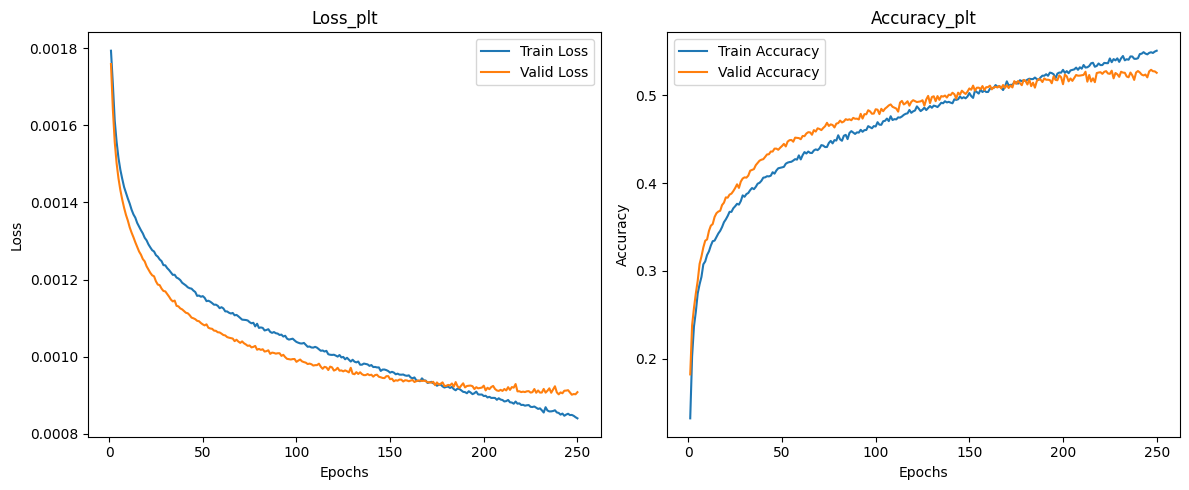

In [12]:
# SGD（0.9）+ fucal + bs256 + relu + lr0.01 + dropout0.1 + epoch250

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# 线性层
class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001, momentum=0.9):
        self.W = np.random.normal(scale=0.01, size=(n_in, n_out))
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.momentum = momentum
        self.batch_size = batch_size
        
        # 初始化动量项为 0
        self.vW = np.zeros_like(self.W)
        self.vb = np.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output

    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0)
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout

        # 更新动量项
        self.vW = self.momentum * self.vW + (1 - self.momentum) * self.dW
        self.vb = self.momentum * self.vb + (1 - self.momentum) * self.db

        # 更新权重和偏置
        self.W = self.W - self.lr * self.vW / self.batch_size
        self.b = self.b - self.lr * self.vb / self.batch_size
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout

class Dropout:
    def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate
        self.mask = None

    def forward(self, x, training=True):
        if training:
            # 在训练时生成一个mask，用于随机关闭神经元
            self.mask = np.random.binomial(1, 1 - self.dropout_rate, size=x.shape) / (1 - self.dropout_rate)
            return x * self.mask
        else:
            # 在测试时，直接返回输入数据
            return x

    def backward(self, dout):
        # 反向传播时只传播未关闭神经元的梯度
        return dout * self.mask

# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, hidden_layer_sizes=(256,), activation='relu', dropout_rate=0.15):
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        self.dropout1 = Dropout(dropout_rate)  # 第一个 Dropout
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, None, lr=lr)
        self.dropout2 = Dropout(dropout_rate)  # 第二个 Dropout
        self.softmax = SoftMax()

        self.layers = [self.input_layer, self.dropout1]  # 加入 Dropout1
        for i in range(len(hidden_layer_sizes) - 1):
            self.layers.append(LinearLayer(hidden_layer_sizes[i], hidden_layer_sizes[i + 1], batch_size, activation, lr=lr))
        self.layers.append(self.classifier)
        self.layers.append(self.dropout2)  # 加入 Dropout2
        self.layers.append(self.softmax)

    def forward(self, x, training=True):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, training)  # 在训练时使用 Dropout
            else:
                x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)
            
# Focal Loss实现
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    # 加1e-8防止log(0)
    epsilon = 1e-8
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)  # 避免数值溢出问题
    
    # 计算交叉熵损失
    cross_entropy = -y_true * np.log(y_pred)
    
    # 计算 Focal Loss 的权重
    weight = alpha * np.power(1 - y_pred, gamma)
    
    # 计算最终的 Focal Loss
    focal_loss = weight * cross_entropy
    return np.mean(np.sum(focal_loss, axis=1))

# 下载并加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 250
batch_size = 256

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.01, hidden_layer_sizes=(256,), activation='relu')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播（训练时启用 Dropout）
            outputs = model.forward(data, training=True)
            loss = focal_loss(label, outputs, gamma=2.0, alpha=0.25)  # Focal 损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段（禁用 Dropout）
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播（验证时禁用 Dropout）
            outputs = model.forward(data, training=False)
            loss = focal_loss(label, outputs, gamma=2.0, alpha=0.25)  # Focal 损失
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)
    

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            # 测试时禁用 Dropout
            outputs = model.forward(data, training=False)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()
